In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import packages

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import numpy as np
from tqdm import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Import Label File

In [6]:
label_data = pd.read_csv("/kaggle/input/classes/class_names.txt", sep=' ', header=None)
label_data.columns=['index', 'labels']
label_data = label_data.drop(['index'], axis=1)
label_data.head()

,labels
0,BaseballPitch
1,Basketball
2,BenchPress
3,Biking
4,Billiards


# Setting path For data

In [7]:
path=[]
for label in label_data.labels.values:
    path.append('/kaggle/input/ucf50-action-recognition-dataset/UCF50/'+label+"/")
path[3]

'/kaggle/input/ucf50-action-recognition-dataset/UCF50/Biking/'

# Data Preperation

In [8]:
#Function for Feature Extraction
def feature_extraction(video_path):
    width=64
    height=64
    sequence_length=15
    frames_list=[]
    #Read the Video
    video_reader = cv2.VideoCapture(video_path)
    #get the frame count
    frame_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    #Calculate the interval after which frames will be added to the list
    skip_interval = max(int(frame_count/sequence_length), 1)
    #iterate through video frames
    for counter in range(sequence_length):
        #Set the current frame postion of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        #Read the current frame 
        ret, frame = video_reader.read()
        if not ret:
            break;
        #Resize the image
        frame=cv2.resize(frame, (height, width))
        frame = frame/255
        #Append to the frame
        frames_list.append(frame)
    video_reader.release()
    #Return the Frames List
    return frames_list

In [9]:
#Function for loading video files, Process and store in a data set
def load_video(datasets):
    global image
    label_index=0
    labels=[]
    images=[]
    #Iterate through each foler corresponding to category
    for folder in datasets:
        for file in tqdm(os.listdir(folder)):
            #Get the path name for each video
            video_path = os.path.join(folder, file)
            #Extract the frames of the current video
            frames_list = feature_extraction(video_path)
            images.append(frames_list)
            labels.append(label_index)
        label_index+=1
    return np.array(images, dtype='float16'), np.array(labels, dtype='int8')

In [10]:
#Use the first 10 video classes for training the model for demonstration.
images, labels = load_video(path[:50])

100%|██████████| 128/128 [00:07<00:00, 16.27it/s]


In [11]:
images[0].shape

(15, 64, 64, 3)

In [12]:
#Train Test Split
x_train, x_test, y_train, y_test=train_test_split(images, labels, test_size=.20, random_state=42)
x_train.shape, x_test.shape, np.array(y_train).shape, np.array(y_test).shape

((5344, 15, 64, 64, 3), (1337, 15, 64, 64, 3), (5344,), (1337,))

## The Existing model: CNN (Conv2D)

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GRU, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, TimeDistributed
from tensorflow.keras.regularizers import l2

model = Sequential()

# Convolutional layers
model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
                          input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3], 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((4, 4))))
model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((4, 4))))
model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.3)))

model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(Flatten()))

# Recurrent layer
model.add(GRU(156, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
# Dense layer
model.add(Dense(50, activation='softmax'))

# Display the model's summary
#model.summary()


In [64]:
# Choose one of the following optimizers for multiclass classification:
#optim = 'adam'
#optim = 'sgd'
#optim= 'rmsprop'
#optim= 'nadam'
#optim= 'adagrad'
#optim= 'adadelta'
#optim= 'ftrl'
#optim= 'categorical_hinge'
#optim= 'kullback_leibler_divergence'
loss = 'categorical_crossentropy'  # Use this if your labels are one-hot encoded
# or
#loss = 'sparse_categorical_crossentropy'  # Use this if your labels are integers
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
custom_learning_rate = 0.0001
custom_optimizer = Adam(learning_rate=custom_learning_rate)
#custom_optimizer = SGD(learning_rate=custom_learning_rate)
#custom_optimizer = RMSprop(learning_rate=custom_learning_rate)
#compile model
model.compile(loss=loss, optimizer=custom_optimizer, metrics='accuracy')

In [65]:
#Model training
#filepath = "model.h5"
es = EarlyStopping(monitor='val_loss', patience=45, mode='min', restore_best_weights=True)
history = model.fit(x_train, to_categorical(y_train), batch_size=16, epochs=200, validation_data=(x_test, to_categorical(y_test)), callbacks=[es])
# Save the trained model to a file
model.save("my_model_adam_lr(0.0001)_B16_f15_BaN_Drp3_GRUD5.h5")


Epoch 1/200
334/334 [==============================] - 18s 47ms/step - loss: 4.9059 - accuracy: 0.0269 - val_loss: 4.7377 - val_accuracy: 0.0262
Epoch 2/200
334/334 [==============================] - 12s 37ms/step - loss: 4.5946 - accuracy: 0.0543 - val_loss: 4.2983 - val_accuracy: 0.0718
Epoch 3/200
334/334 [==============================] - 12s 37ms/step - loss: 4.3666 - accuracy: 0.0829 - val_loss: 3.9310 - val_accuracy: 0.1511
Epoch 4/200
334/334 [==============================] - 12s 37ms/step - loss: 4.2122 - accuracy: 0.1027 - val_loss: 3.8158 - val_accuracy: 0.1668
Epoch 5/200
334/334 [==============================] - 12s 37ms/step - loss: 4.0300 - accuracy: 0.1334 - val_loss: 3.6632 - val_accuracy: 0.1877
Epoch 6/200
334/334 [==============================] - 12s 37ms/step - loss: 3.8983 - accuracy: 0.1564 - val_loss: 3.5467 - val_accuracy: 0.2191
Epoch 7/200
334/334 [==============================] - 12s 37ms/step - loss: 3.7370 - accuracy: 0.1720 - val_loss: 3.4400 - val_ac

In [ ]:
import matplotlib.pyplot as plt

# Access training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig("my_model_adam_lr(0.0001)_B8_f15_AccCurves(grud5).jpg")
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.savefig("my_model_adam_lr(0.0001)_B8_f15_Loss_Curves(grud5).jpg")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

# Define the path to your saved model file
model_path = '/kaggle/working/my_model_adam_lr(0.0001)_B8_f15_BaN_Drp3.h5'  # Replace with the actual file path

# Load the model from the specified path
loaded_model = load_model(model_path)

# Assuming you have a new data array x_test
y_pred = loaded_model.predict(x_test)

# To get the predicted classes (assuming a classification task):
predicted_classes = [np.argmax(y) for y in y_pred]

# Now you have the predicted classes based on the loaded model.


In [56]:
y_pred = model.predict(x_test)
predicted_classes=[]
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))

42/42 [==============================] - 1s 18ms/step


In [57]:
#Test Accuracy
accuracy_score(y_test, predicted_classes)

0.9409124906507106

In [58]:
import pandas as pd

# Read the text file into a DataFrame
label_data = pd.read_csv("/kaggle/input/classes/class_names.txt", sep=' ', header=None)
label_data.columns = ['index', 'labels']

# Drop the 'index' column
label_data = label_data.drop(['index'], axis=1)

# Store all the class labels in a Python list
class_labels = label_data['labels'].tolist()

# Print the class labels
print(class_labels)


['BaseballPitch', 'Basketball', 'BenchPress', 'Biking', 'Billiards', 'BreastStroke', 'CleanAndJerk', 'Diving', 'Drumming', 'Fencing', 'GolfSwing', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'JavelinThrow', 'JugglingBalls', 'JumpRope', 'JumpingJack', 'Kayaking', 'Lunges', 'MilitaryParade', 'Mixing', 'Nunchucks', 'PizzaTossing', 'PlayingGuitar', 'PlayingPiano', 'PlayingTabla', 'PlayingViolin', 'PoleVault', 'PommelHorse', 'PullUps', 'Punch', 'PushUps', 'RockClimbingIndoor', 'RopeClimbing', 'Rowing', 'SalsaSpin', 'SkateBoarding', 'Skiing', 'Skijet', 'SoccerJuggling', 'Swing', 'TaiChi', 'TennisSwing', 'ThrowDiscus', 'TrampolineJumping', 'VolleyballSpiking', 'WalkingWithDog', 'YoYo']


In [59]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Assuming 'y_test' contains the true labels for your test data
# 'predicted_classes' contains the predicted class labels from your model

# Calculate precision, recall, and F1-score for all classes
precision = precision_score(y_test, predicted_classes, average=None)
recall = recall_score(y_test, predicted_classes, average=None)
f1 = f1_score(y_test, predicted_classes, average=None)
'''
# Print the results for each class
for class_idx in range(len(precision)):
    print(f"Class {class_idx}:")
    print(f"Precision: {precision[class_idx]:.2f}")
    print(f"Recall: {recall[class_idx]:.2f}")
    print(f"F1-score: {f1[class_idx]:.2f}")
    print()
'''
# Generate a classification report
class_names = class_labels  # Class names as strings
classification_rep = classification_report(y_test, predicted_classes, target_names=class_names)
print("Classification Report:")
print(classification_rep)


Classification Report:
                    precision    recall  f1-score   support

     BaseballPitch       0.94      1.00      0.97        34
        Basketball       0.94      0.88      0.91        33
        BenchPress       0.97      1.00      0.99        38
            Biking       0.83      0.88      0.85        33
         Billiards       1.00      1.00      1.00        25
      BreastStroke       0.96      1.00      0.98        24
      CleanAndJerk       1.00      1.00      1.00         9
            Diving       0.97      0.97      0.97        36
          Drumming       0.94      0.97      0.96        33
           Fencing       0.95      1.00      0.98        20
         GolfSwing       0.97      0.88      0.92        41
          HighJump       1.00      0.89      0.94        27
         HorseRace       0.89      0.96      0.93        26
       HorseRiding       0.95      0.97      0.96        37
          HulaHoop       1.00      0.92      0.96        13
      JavelinThr

Precision: 0.94
Recall: 0.94
F1-score: 0.94


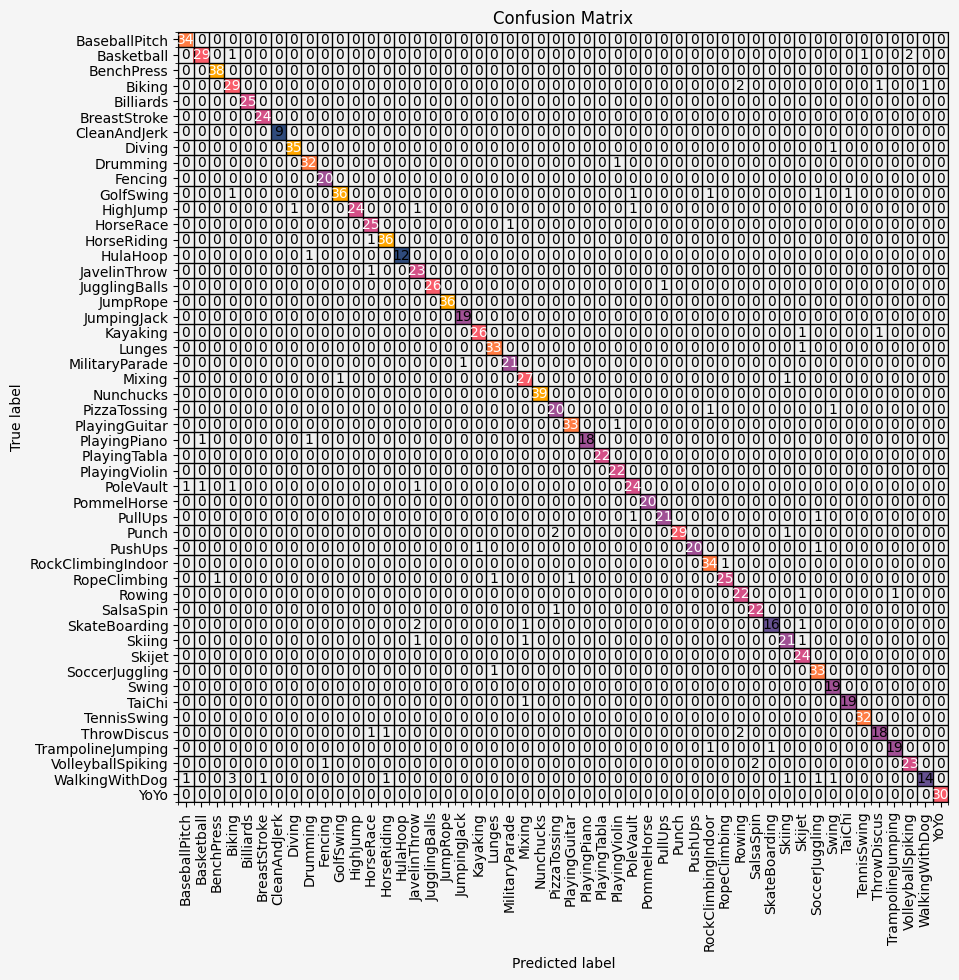

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels

# Assuming you have already defined 'y_test' and 'predicted_classes'
# Assuming you have also defined 'class_labels'

# Get unique labels from y_test and predicted_classes
unique_labels = unique_labels(y_test, predicted_classes)

# Compute the confusion matrix
confusion = confusion_matrix(y_test, predicted_classes, labels=unique_labels)

# Define your custom colormap using the specified colors
custom_cmap = plt.cm.colors.ListedColormap(["#f0f0f0", "#003f5c", "#2f4b7c", "#665191", "#a05195", "#d45087", "#f95d6a", "#ff7c43", "#ffa600"])

# Create a figure and axis for the plot with an adjusted figure size
fig, ax = plt.subplots(figsize=(25, 10))  # You can adjust the size as needed
fig.patch.set_facecolor('#F5F5F5')
# Create a grid to separate the blocks
ax.set_xticks(np.arange(len(unique_labels) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(unique_labels) + 1) - 0.5, minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=1)

# Plot the confusion matrix using the custom colormap
im = ax.imshow(confusion, interpolation='nearest', cmap=custom_cmap)

# Set title and axis labels
ax.set_title('Confusion Matrix')
ax.set_xticks(np.arange(len(unique_labels)))
ax.set_yticks(np.arange(len(unique_labels)))
ax.set_xticklabels(class_labels, rotation=90)  # Replace with your class labels
ax.set_yticklabels(class_labels)  # Replace with your class labels
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Loop over data dimensions and create text annotations
for i in range(len(unique_labels)):
    for j in range(len(unique_labels)):
        ax.text(j, i, str(confusion[i, j]), ha="center", va="center", color="white" if confusion[i, j] > confusion.max() / 2 else "black")

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
f1 = f1_score(y_test, predicted_classes, average='weighted')

# Display precision, recall, and F1-score
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the plot as a JPG file
plt.savefig('confusion_matrix_my_model_adam_lr(0.0001)_B2_f15(grud5Acc94).jpg', format='jpg')

# Display the plot
plt.show()


In [28]:
'''
import os

working_dir = '/kaggle/working'  # This is the path to your Kaggle working directory

# List all files and directories in the working directory
files = os.listdir(working_dir)

# Delete all files in the working directory
for file in files:
    file_path = os.path.join(working_dir, file)
    if os.path.isfile(file_path):
        os.remove(file_path)
'''